This notebook is to develop and test lib/stabilizer.py

TO DO

# lib/stabilizer.py

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import stim
from lib.stabilizer import measurement_gadgets, StabilizerCode, stabilizer_circuits
from lib.color_compass import Lattice2D, compass_to_surface
from lib.decoder import checkmatrix,pL_from_checkmatrix
from utils.stim2pymatching import logical_error_rate_noisy_graph

# Measurement gadgets

## Unitary verification between `cnot` and `hadamard` construction

In [2]:
H = np.array([[1,1],[1,-1]])/np.sqrt(2)
I = np.eye(2)
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
S = np.array([[1,0],[0,1j]])
zero = np.array([[1,0],[0,0]])
one = np.array([[0,0],[0,1]])
CNOT = np.kron(zero,I) + np.kron(one,X)
NOTC = np.kron(I,zero) + np.kron(X,one)

In [3]:
hadamard_X = np.kron(I,H) @ (np.kron(I,zero) + np.kron(X,one)) @ np.kron(I,H)
hadamard_Y = np.kron(I,H) @ (np.kron(I,zero) + np.kron(Y,one)) @ np.kron(I,H)
hadamard_Z = np.kron(I,H) @ (np.kron(I,zero) + np.kron(Z,one)) @ np.kron(I,H)

cnot_Z = CNOT
cnot_X = np.kron(H,I)@CNOT@np.kron(H,I)
cnot_Y = np.kron(S@H,I)@CNOT@np.kron(H@S.conj().T,I)

print(f'Difference in \n X: {abs(hadamard_X-cnot_X).max()}\n Y: {abs(hadamard_Y-cnot_Y).max()}\n Z: {abs(hadamard_Z-cnot_Z).max()}')

Difference in 
 X: 0.0
 Y: 0.0
 Z: 2.220446049250313e-16


## Basic call

In [4]:
code = ['IIZZ','XZYY']
# gate_noise1 = 'DEPOLARIZE1(0.01)'
# gate_noise1 = 'PAULI_CHANNEL_1(0.02, 0.05, 0.1)'
# gate_noise2 = 'DEPOLARIZE2(0.01)'
# meas_noise = 'X_ERROR(0.01)'
gate_noise1 = None #'PAULI_CHANNEL_1(0.02, 0.05, 0.1)'
gate_noise2 = None #'DEPOLARIZE2(0.01)'
meas_noise = None #'X_ERROR(0.01)'
print('\ncnot:\n',measurement_gadgets(code, 
                                      'cnot', 
                                      gate_noise1, 
                                      gate_noise2, 
                                      meas_noise))
print('\nhadamard:\n',measurement_gadgets(code, 
                                          'hadamard', 
                                          gate_noise1, 
                                          gate_noise2, 
                                          meas_noise))


cnot:
 [stim.Circuit('''
    CX 2 4 3 4
    MR 4
'''), stim.Circuit('''
    S_DAG 2 3
    H 0 2 3
    CX 0 5 1 5 2 5 3 5
    H 0 2 3
    S 2 3
    MR 5
''')]

hadamard:
 [stim.Circuit('''
    H 4
    CZ 4 2 4 3
    H 4
    MR 4
'''), stim.Circuit('''
    H 5
    CX 5 0
    CY 5 2 5 3
    CZ 5 1
    H 5
    MR 5
''')]


# Add detectors, multi-round

In [10]:
stabilizers = ['XZZXI', 'IXZZX', 'XIXZZ', 'ZXIXZ']
logicals = ['XXXXX','ZZZZZ']
# stabilizers = ['ZZI', 'IZZ']
# logical = ['ZII']

# only works for CSS code for now
# stabilizers = ['XXIXXII','XIXXIIX','IIIXXXX','ZZIZZII','ZIZZIIZ','IIIZZZZ']
# stabilizers = ['XX_XX__','X_XX__X','___XXXX','ZZ_ZZ__','Z_ZZ__Z','___ZZZZ']
# logicals = ['XXXXXXX','ZZZZZZZ']

gate_noise1 = None #'PAULI_CHANNEL_1(0.02, 0.05, 0.1)'
gate_noise2 = None #'DEPOLARIZE2(0.01)'
meas_noise = None #'X_ERROR(0.01)'
noise = (gate_noise1,gate_noise2,meas_noise)
rounds = 3
perfect_encoding = True
perfect_logical_meas = True
construction = 'cnot'

circuits = stabilizer_circuits(stabilizers, logicals, noise, rounds, construction, perfect_encoding, perfect_logical_meas)

In [13]:
num_shots = 10
print(circuits[0].compile_sampler().sample(num_shots))#[:,[0,1,-1]])
print(circuits[1].compile_sampler().sample(num_shots))#[:,[0,1,-1]])

[[0 0 1 0 0 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 1 1 0 0 1 1 0 0 1 1 1]
 [0 0 1 0 0 1 1 0 0 1 1 0 0 1 0]
 [0 1 0 1 0 0 0 1 0 0 0 1 0 0 1]
 [0 0 0 0 1 0 0 0 1 0 0 0 1 0 0]
 [0 1 0 1 0 0 0 1 0 0 0 1 0 0 1]
 [0 1 1 0 0 0 1 0 0 0 1 0 0 0 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
[[0 0 1 0 0 1 1 0 0 1 1 0 0 1 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 1]
 [0 0 1 0 1 1 1 0 1 1 1 0 1 1 0]
 [0 0 1 1 0 0 1 1 0 0 1 1 0 0 0]
 [1 0 0 0 1 0 0 0 1 0 0 0 1 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 1 1 1 0 1 1 1 0 1 1 0]
 [0 1 0 1 0 1 0 1 0 1 0 1 0 1 1]
 [1 1 1 0 1 1 1 0 1 1 1 0 1 1 1]
 [0 0 1 0 1 0 1 0 1 0 1 0 1 0 0]]


In [23]:
shots = circuits[1].compile_sampler().sample(num_shots)
shots

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
       [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
       [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1],
       [0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1],
       [0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0]], dtype=uint8)

In [29]:
shots[:,2:-1]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
       [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
       [1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]], dtype=uint8)

# No noise verification
- Initial and final logical measurements are the same
- All syndromes are 0
## CSS 7-qubit code

In [48]:
stabilizers = ['XX_XX__','X_XX__X','___XXXX','ZZ_ZZ__','Z_ZZ__Z','___ZZZZ']
logicals = ['XXXXXXX','ZZZZZZZ']

noise = (None,None,None)
num_shots = 10

for construction in ['cnot','hadamard']:
    print(construction)
    for rounds in np.random.randint(1,10,size=3):
        print(f'- rounds = {rounds}')
        fails = 0
        circuits = stabilizer_circuits(stabilizers, logicals, noise, rounds, construction)
        for i in range(2):
            shots = circuits[i].compile_sampler().sample(num_shots)
            observables = shots[:,[1,-1]]
            syndromes = shots[:,2:-1]
            if (observables.sum(1)%2).sum() or syndromes.sum():
                print(lat)
                fails += 1
        print(f'\tFail rate {fails/2}')

cnot
- rounds = 3
	Fail rate 0.0
- rounds = 3
	Fail rate 0.0
- rounds = 7
	Fail rate 0.0
hadamard
- rounds = 8
	Fail rate 0.0
- rounds = 9
	Fail rate 0.0
- rounds = 6
	Fail rate 0.0


## (Issue) 5-qubit code 
- Non-CSS code doesn't work

In [49]:
stabilizers = ['XZZXI', 'IXZZX', 'XIXZZ', 'ZXIXZ']
logicals = ['XXXXX','ZZZZZ']

noise = (None,None,None)
num_shots = 10

for construction in ['cnot','hadamard']:
    print(construction)
    for rounds in np.random.randint(1,10,size=3):
        print(f'- rounds = {rounds}')
        fails = 0
        circuits = stabilizer_circuits(stabilizers, logicals, noise, rounds, construction)
        for i in range(2):
            shots = circuits[i].compile_sampler().sample(num_shots)
            observables = shots[:,[1,-1]]
            syndromes = shots[:,2:-1]
            if (observables.sum(1)%2).sum() or syndromes.sum():
                fails += 1
        print(f'\tFail rate {fails/2}')

cnot
- rounds = 2
	Fail rate 1.0
- rounds = 9
	Fail rate 1.0
- rounds = 3
	Fail rate 1.0
hadamard
- rounds = 9
	Fail rate 1.0
- rounds = 6
	Fail rate 1.0
- rounds = 9
	Fail rate 1.0


## Color compass code

In [52]:
dim = 8
lat = Lattice2D(dim, dim)
failures = []

noise = (None,None,None)
num_shots = 10
num_configs = 100

for construction in ['cnot','hadamard']:
    print(construction)
    for rounds in np.random.randint(1,10,size=3):
        print(f'- rounds = {rounds}')
        fails = 0
        colorings = np.random.randint(-1,1,size=(num_configs,(dim-1)**2))
        for c in colorings:
            lat.color_lattice(c)
            circuits = stabilizer_circuits(lat.getS(), lat.logicals, noise, rounds, construction)
            for i in range(2):
                shots = circuits[i].compile_sampler().sample(num_shots)
                observables = shots[:,[1,-1]]
                syndromes = shots[:,2:-1]
                if (observables.sum(1)%2).sum() or syndromes.sum():
                    # print(lat)
                    fails += 1
        print(f'\tFail rate {fails/len(colorings)/2}')

cnot
- rounds = 9
	Fail rate 0.0
- rounds = 8
	Fail rate 0.0
- rounds = 9
	Fail rate 0.0
hadamard
- rounds = 1
	Fail rate 0.0
- rounds = 1
	Fail rate 0.0
- rounds = 8
	Fail rate 0.0


## Some noise: fail rate is non-zero

In [66]:
dim = 5
lat = Lattice2D(dim, dim)
failures = []

noise_level = 1e-4
gate_noise1 = f'PAULI_CHANNEL_1({noise_level}, {noise_level}, {noise_level})'
gate_noise2 = f'DEPOLARIZE2({noise_level})'
meas_noise = f'X_ERROR({noise_level})'
noise = (gate_noise1,gate_noise2,meas_noise)
# noise = (None,None,None)
num_shots = 10
num_configs = 100

for construction in ['cnot','hadamard']:
    print(construction)
    for rounds in np.random.randint(1,10,size=3):
        print(f'- rounds = {rounds}')
        fails = 0
        colorings = np.random.randint(-1,1,size=(num_configs,(dim-1)**2))
        for c in colorings:
            lat.color_lattice(c)
            circuits = stabilizer_circuits(lat.getS(), lat.logicals, noise, rounds, construction)
            for i in range(2):
                shots = circuits[i].compile_sampler().sample(num_shots)
                observables = shots[:,[1,-1]]
                syndromes = shots[:,2:-1]
                if (observables.sum(1)%2).sum() or syndromes.sum():
                    # print(lat)
                    fails += 1
        print(f'\tFail rate {fails/len(colorings)/2}')

cnot
- rounds = 8
	Fail rate 0.89
- rounds = 4
	Fail rate 0.765
- rounds = 4
	Fail rate 0.68
hadamard
- rounds = 8
	Fail rate 0.725
- rounds = 4
	Fail rate 0.445
- rounds = 4
	Fail rate 0.36


# Case study: surface code , benchmark to stim

## pL vs. rounds

In [57]:
# surface code
dim = 3
lat = compass_to_surface(dim,dim,'X')
encoding = 'reset_Z'
logical = lat.logicals[0] if 'X' in encoding else lat.logicals[1]
after_encode_unitary = 'I'*dim**2
# after_encode_unitary = lat.logicals[0]
# after_encode_unitary = 'XXXXXXXXX'
rounds = 9

noise_level = 3e-3
# gate_noise1 = f'PAULI_CHANNEL_1({noise_level}, {noise_level}, {noise_level})'
gate_noise1 = f'DEPOLARIZE1({noise_level})'
gate_noise2 = f'DEPOLARIZE2({noise_level})'
meas_noise = f'X_ERROR({noise_level})'
noise = (gate_noise1,gate_noise2,meas_noise)

circuit = stabilizer_circuits(lat, encoding, after_encode_unitary, noise,
                              rounds, meas_logical_via_ancilla=False)

In [101]:
num_shots = int(1e4)
diff_rounds = [1,3,5,7,9]
pLs = []
enc_pLs = []
anc_pLs = []
stim_pLs = []

for rounds in diff_rounds:
    print(f'Running for rounds = {rounds}')
    circuit = stabilizer_circuits(lat, encoding, after_encode_unitary, noise,
                                  rounds, meas_logical_via_ancilla=False)
    
    enc_circuit = stabilizer_circuits(lat, 'encode_Z', after_encode_unitary, noise,
                                  rounds, meas_logical_via_ancilla=False)
    
    anc_circuit = stabilizer_circuits(lat, encoding, after_encode_unitary, noise,
                                  rounds, meas_logical_via_ancilla=True)
    
    stim_circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=rounds,
            distance=dim,
            after_clifford_depolarization=noise_level,
            before_measure_flip_probability=noise_level)

    pLs.append(estimate_pL_noisy_graph(circuit, num_shots))
    enc_pLs.append(estimate_pL_noisy_graph(enc_circuit, num_shots))
    anc_pLs.append(estimate_pL_noisy_graph(anc_circuit, num_shots))
    stim_pLs.append(estimate_pL_noisy_graph(stim_circuit, num_shots))

pLs = np.array(pLs)
enc_pLs = np.array(enc_pLs)
anc_pLs = np.array(anc_pLs)
stim_pLs = np.array(stim_pLs)

Running for rounds = 1
Running for rounds = 3
Running for rounds = 5
Running for rounds = 7
Running for rounds = 9


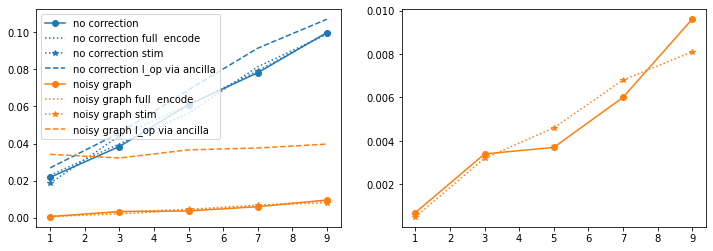

In [105]:
labels = ['no correction','noisy graph']
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for i in range(2):
    plt.plot(diff_rounds,pLs[:,i],f'C{i}o-',label=labels[i])
    plt.plot(diff_rounds,enc_pLs[:,i],f'C{i}:',label=labels[i]+' full  encode')
    plt.plot(diff_rounds,stim_pLs[:,i],f'C{i}*:',label=labels[i]+' stim')
    plt.plot(diff_rounds,anc_pLs[:,i],f'C{i}--',label=labels[i]+' l_op via ancilla')
plt.legend()

plt.subplot(1,2,2)
i = 1    
plt.plot(diff_rounds,pLs[:,i],f'C{i}o-',label=labels[i])
plt.plot(diff_rounds,stim_pLs[:,i],f'C{i}*:',label=labels[i]+' stim')

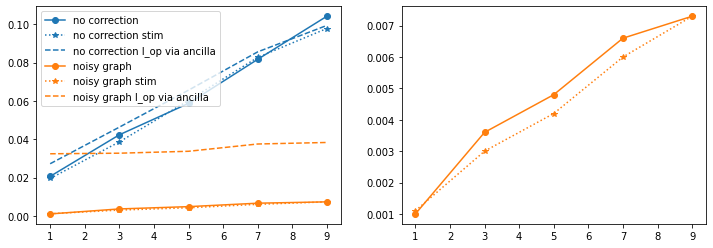

## pL vs. physical error

In [62]:
num_shots = int(1e4)
pLs = []
anc_pLs = []
stim_pLs = []

noise_levels = [3e-3,5e-3,7e-3,1e-2]
distances = [3,5,7]
pLs = np.zeros((len(noise_levels),len(distances)))
stim_pLs = np.zeros((len(noise_levels),len(distances)))

for i,noise_level in enumerate(noise_levels):

    gate_noise1 = f'DEPOLARIZE1({noise_level})'
    gate_noise2 = f'DEPOLARIZE2({noise_level})'
    meas_noise = f'X_ERROR({noise_level})'
    noise = (gate_noise1,gate_noise2,meas_noise)
    
    for j,dim in enumerate(distances):
        print(f'Running for noise = {noise_level}, distance = {dim}')
        lat = compass_to_surface(dim,dim,'X')
        after_encode_unitary = 'I'*dim**2        
        rounds = 3*dim
        circuit = stabilizer_circuits(lat, encoding, after_encode_unitary, noise,
                                      rounds, meas_logical_via_ancilla=False)
    
        stim_circuit = stim.Circuit.generated(
                "surface_code:rotated_memory_z",
                rounds=rounds,
                distance=dim,
                after_clifford_depolarization=noise_level,
                before_measure_flip_probability=noise_level)

        pLs[i,j] = estimate_pL_noisy_graph(circuit, num_shots)[1]
        stim_pLs[i,j] = estimate_pL_noisy_graph(stim_circuit, num_shots)[1]

Running for noise = 0.003, distance = 3
Running for noise = 0.003, distance = 5
Running for noise = 0.003, distance = 7
Running for noise = 0.005, distance = 3
Running for noise = 0.005, distance = 5
Running for noise = 0.005, distance = 7
Running for noise = 0.007, distance = 3
Running for noise = 0.007, distance = 5
Running for noise = 0.007, distance = 7
Running for noise = 0.01, distance = 3
Running for noise = 0.01, distance = 5
Running for noise = 0.01, distance = 7


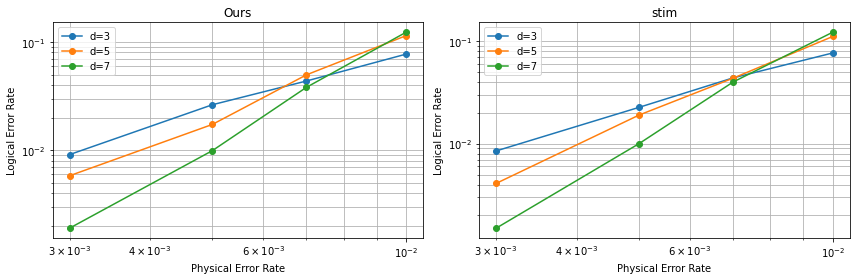

In [82]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for j,dim in enumerate(distances):
    plt.loglog(noise_levels,pLs[:,j],f'C{j}o-',label=f'd={dim}')
    # plt.loglog(noise_levels,stim_pLs[:,j],f'C{j}*--',label=f'd={dim} stim')
plt.grid(which='major')
plt.grid(which='minor')
plt.legend()
plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Ours')

plt.subplot(1,2,2)
for j,dim in enumerate(distances):
    plt.loglog(noise_levels,stim_pLs[:,j],'o-',label=f'd={dim}')
plt.grid(which='major')
plt.grid(which='minor')
plt.legend()
plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('stim')

plt.tight_layout()
plt.show()

In [85]:
# np.save('data/benchmark_surface_error_ours.npy',pLs)
# np.save('data/benchmark_surface_error_stim.npy',stim_pLs)

## Time performance

In [95]:
%%timeit
stim_circuit = stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        rounds=rounds,
        distance=dim,
        after_clifford_depolarization=noise_level,
        before_measure_flip_probability=noise_level)
estimate_pL_noisy_graph(stim_circuit, num_shots)

7.16 s ± 171 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [96]:
%%timeit
gate_noise1 = f'DEPOLARIZE1({noise_level})'
gate_noise2 = f'DEPOLARIZE2({noise_level})'
meas_noise = f'X_ERROR({noise_level})'
noise = (gate_noise1,gate_noise2,meas_noise)
lat = compass_to_surface(dim,dim,'X')

circuit = stabilizer_circuits(lat, encoding, after_encode_unitary, noise,
                              rounds, meas_logical_via_ancilla=False)
estimate_pL_noisy_graph(circuit, num_shots)

7.11 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [97]:
%%prun -s cumulative -q -l 30 -T prun0
stim_circuit = stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        rounds=rounds,
        distance=dim,
        after_clifford_depolarization=noise_level,
        before_measure_flip_probability=noise_level)
estimate_pL_noisy_graph(stim_circuit, num_shots)

 
*** Profile printout saved to text file 'prun0'. 


In [98]:
print(open('prun0', 'r').read())

         534861 function calls (494708 primitive calls) in 5.638 seconds

   Ordered by: cumulative time
   List reduced from 116 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.002    0.002    5.638    5.638 {built-in method builtins.exec}
        1    0.000    0.000    5.636    5.636 <string>:1(<module>)
        1    0.011    0.011    5.636    5.636 3917766421.py:1(estimate_pL_noisy_graph)
        1    0.007    0.007    5.624    5.624 stim2pymatching.py:165(logical_error_rate_noisy_graph)
        1    0.035    0.035    5.546    5.546 stim2pymatching.py:15(predict_observable_errors_using_pymatching)
    10000    0.035    0.000    5.333    0.001 matching.py:229(decode)
    10000    5.153    0.001    5.153    0.001 {built-in method pymatching._cpp_mwpm.decode_match_neighbourhood}
62690/22538    0.064    0.000    0.296    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    10000    0.007  

In [99]:
%%prun -s cumulative -q -l 30 -T prun0
gate_noise1 = f'DEPOLARIZE1({noise_level})'
gate_noise2 = f'DEPOLARIZE2({noise_level})'
meas_noise = f'X_ERROR({noise_level})'
noise = (gate_noise1,gate_noise2,meas_noise)
lat = compass_to_surface(dim,dim,'X')

circuit = stabilizer_circuits(lat, encoding, after_encode_unitary, noise,
                              rounds, meas_logical_via_ancilla=False)
estimate_pL_noisy_graph(circuit, num_shots)

 
*** Profile printout saved to text file 'prun0'. 


In [100]:
print(open('prun0', 'r').read())

         538727 function calls (498290 primitive calls) in 5.714 seconds

   Ordered by: cumulative time
   List reduced from 160 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    5.714    5.714 {built-in method builtins.exec}
        1    0.001    0.001    5.713    5.713 <string>:1(<module>)
        1    0.010    0.010    5.701    5.701 3917766421.py:1(estimate_pL_noisy_graph)
        1    0.007    0.007    5.691    5.691 stim2pymatching.py:165(logical_error_rate_noisy_graph)
        1    0.035    0.035    5.615    5.615 stim2pymatching.py:15(predict_observable_errors_using_pymatching)
    10000    0.036    0.000    5.401    0.001 matching.py:229(decode)
    10000    5.216    0.001    5.216    0.001 {built-in method pymatching._cpp_mwpm.decode_match_neighbourhood}
63055/22619    0.066    0.000    0.300    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    10000    0.007  

# Add pL from check matrix (in progress)

In [11]:
shots = circuit.compile_detector_sampler().sample(num_shots, append_observables=True)
detector_parts = shots[:, :circuit.num_detectors]
observables = shots[:, circuit.num_detectors:]
pL_no_correction = observables.flatten().mean()

# syndromes = detector_parts.reshape(num_shots,-1,circuit.num_detectors//rounds).swapaxes(1,2)
# syndromes_x = syndromes[:,:len(lat.getSx())]
# syndromes_z = syndromes[:,len(lat.getSx()):]

pL_noisy = logical_error_rate_noisy_graph(circuit,
                                          detector_parts,
                                          observables)
# l_op = stim.PauliString(logical)
# pL_check_Z = pL_from_checkmatrix(l_op,Hz,rounds,syndromes_z,observables,CSS_error='X')
# pL_check_XZ = pL_from_checkmatrix(l_op,H,rounds,syndromes,observables)

print('- noisy graph:', pL_noisy)
# print('- checkmat  Z:', pL_check_Z)
# print('- checkmat XZ:', pL_check_XZ)
print('- no correct :', pL_no_correction)

- noisy graph: 0.0105
- no correct : 0.0972


In [389]:
# surface code
dim = 3
dimX,dimZ = dim,dim
lat = compass_to_surface(dimX,dimZ,'X')

rounds = 9
num_shots = 5000

# check matrix
Hx = checkmatrix(lat.getSx(),single_type=True)
Hz = checkmatrix(lat.getSz(),single_type=True)
H = np.vstack([np.hstack([Hx,np.zeros_like(Hx)]),np.hstack([np.zeros_like(Hz),Hz])])

# noise level
noise_level = 3e-3
# gate_noise1 = f'PAULI_CHANNEL_1({noise_level}, {noise_level}, {noise_level})'
gate_noise1 = f'DEPOLARIZE1({noise_level})'
gate_noise2 = f'DEPOLARIZE2({noise_level})'
meas_noise = f'X_ERROR({noise_level})'
noise = (gate_noise1,gate_noise2,meas_noise)
# noise = (None,None,None)

# logical operator and logical state
Sx, Sz = lat.getSx(), lat.getSz()
logical = lat.logicals[1]
after_encode_unitary = 'I'*len(logical)
# after_encode_unitary = lat.logicals[0]
# after_encode_unitary = 'XXXXXXXXX'
encoding = 'reset_X'
# circuit = stabilizer_circuits(Sx, Sz, dimZ, logical, after_encode_unitary, noise, rounds, construction)
circuit = stabilizer_circuits(lat, after_encode_unitary, noise, rounds, 
                              encoding, meas_logical_via_ancilla=False)
print(circuit)
# shots = circuit.compile_sampler().sample(10)
# print(shots[:,[-3,-6,-9]])
# print(shots[:,[-3,-6,-9]].sum(1)%2)
# circuit.compile_detector_sampler().sample(10,append_observables=True)
# circuit.detector_error_model(decompose_errors=True)

R 9 10 11 12 13 14 15 16
RX 0 1 2 3 4 5 6 7 8
TICK
H 9 10 11 12
DEPOLARIZE1(0.003) 9 10 11 12
TICK
CX 9 0 10 1 11 3 12 5
DEPOLARIZE2(0.003) 9 0 10 1 11 3 12 5
TICK
CX 9 3 10 4 11 6 12 8
DEPOLARIZE2(0.003) 9 3 10 4 11 6 12 8
TICK
CX 10 2 11 4
DEPOLARIZE2(0.003) 10 2 11 4
TICK
CX 10 5 11 7
DEPOLARIZE2(0.003) 10 5 11 7
TICK
H 9 10 11 12
DEPOLARIZE1(0.003) 9 10 11 12
TICK
CX 1 13 4 14 0 15 6 16
DEPOLARIZE2(0.003) 1 13 4 14 0 15 6 16
TICK
CX 2 13 5 14 1 15 7 16
DEPOLARIZE2(0.003) 2 13 5 14 1 15 7 16
TICK
CX 7 14 3 15
DEPOLARIZE2(0.003) 7 14 3 15
TICK
CX 8 14 4 15
DEPOLARIZE2(0.003) 8 14 4 15
TICK
X_ERROR(0.003) 9 10 11 12 13 14 15 16
MR 9 10 11 12 13 14 15 16
DETECTOR(9, 0) rec[-8]
DETECTOR(10, 0) rec[-7]
DETECTOR(11, 0) rec[-6]
DETECTOR(12, 0) rec[-5]
REPEAT 8 {
    H 9 10 11 12
    DEPOLARIZE1(0.003) 9 10 11 12
    TICK
    CX 9 0 10 1 11 3 12 5
    DEPOLARIZE2(0.003) 9 0 10 1 11 3 12 5
    TICK
    CX 9 3 10 4 11 6 12 8
    DEPOLARIZE2(0.003) 9 3 10 4 11 6 12 8
    TICK
    CX 10 2 11 4


In [387]:
shots = circuit.compile_detector_sampler().sample(num_shots, append_observables=True)
detector_parts = shots[:, :circuit.num_detectors]
observables = shots[:, circuit.num_detectors:]
pL_no_correction = observables.flatten().mean()

# syndromes = detector_parts.reshape(num_shots,-1,circuit.num_detectors//rounds).swapaxes(1,2)
# syndromes_x = syndromes[:,:len(lat.getSx())]
# syndromes_z = syndromes[:,len(lat.getSx()):]

pL_noisy = logical_error_rate_noisy_graph(circuit,
                                          detector_parts,
                                          observables)
l_op = stim.PauliString(logical)
# pL_check_Z = pL_from_checkmatrix(l_op,Hz,rounds,syndromes_z,observables,CSS_error='X')
# pL_check_XZ = pL_from_checkmatrix(l_op,H,rounds,syndromes,observables)

print('- noisy graph:', pL_noisy)
# print('- checkmat  Z:', pL_check_Z)
# print('- checkmat XZ:', pL_check_XZ)
print('- no correct :', pL_no_correction)

ValueError: Handling PAULI_CHANNEL_1 requires `approximate_disjoint_errors` argument to be specified.

Circuit stack trace:
    during TICK layer #87 of 92
    at instruction #40 [which is a REPEAT 8 block]
    at block's instruction #17 [which is PAULI_CHANNEL_1(0.003, 0.003, 0.003) 9 10 11 12]

In [335]:
rounds = 9
construction = 'cnot'
num_shots = 5000

# surface code
dim = 3
dimX,dimZ = dim,dim
lat = compass_to_surface(dimX,dimZ,'X')

# check matrix
Hx = checkmatrix(lat.getSx(),single_type=True)
Hz = checkmatrix(lat.getSz(),single_type=True)
H = np.vstack([np.hstack([Hx,np.zeros_like(Hx)]),np.hstack([np.zeros_like(Hz),Hz])])

# noise level
noise_level = 3e-3
# gate_noise1 = f'PAULI_CHANNEL_1({noise_level}, {noise_level}, {noise_level})'
gate_noise1 = f'DEPOLARIZE1({noise_level})'
gate_noise2 = f'DEPOLARIZE2({noise_level})'
meas_noise = f'X_ERROR({noise_level})'
noise = (gate_noise1,gate_noise2,meas_noise)
noise = (None,None,None)

# logical operator and logical state
logical = lat.logicals[1]
after_encode_unitary = 'I'*len(logical)
# after_encode_unitary = lat.logicals[0]

circuit = stabilizer_circuits(lat.getS(), logical, after_encode_unitary, noise, rounds, construction)
# circuit.compile_sampler().sample(num_shots)

shots = circuit.compile_detector_sampler().sample(num_shots, append_observables=True)
detector_parts = shots[:, :circuit.num_detectors]
observables = shots[:, circuit.num_detectors:]
pL_no_correction = observables.flatten().mean()

# syndromes = detector_parts.reshape(num_shots,-1,circuit.num_detectors//rounds).swapaxes(1,2)
# syndromes_x = syndromes[:,:len(lat.getSx())]
# syndromes_z = syndromes[:,len(lat.getSx()):]

pL_noisy = logical_error_rate_noisy_graph(circuit,
                                          detector_parts,
                                          observables)
l_op = stim.PauliString(logical)
# pL_check_Z = pL_from_checkmatrix(l_op,Hz,rounds,syndromes_z,observables,CSS_error='X')
# pL_check_XZ = pL_from_checkmatrix(l_op,H,rounds,syndromes,observables)

print('- noisy graph:', pL_noisy)
# print('- checkmat  Z:', pL_check_Z)
# print('- checkmat XZ:', pL_check_XZ)
print('- no correct :', pL_no_correction)

ValueError: too many values to unpack (expected 3)

In [62]:
pL_noisy = logical_error_rate_noisy_graph(circuit,
                                          detector_parts,
                                          observables)
l_op = stim.PauliString(logical)
pL_check_Z = pL_from_checkmatrix(l_op,Hz,rounds,syndromes_z,observables,CSS_error='X')
pL_check_XZ = pL_from_checkmatrix(l_op,H,rounds,syndromes,observables)

print('- noisy graph:', pL_noisy)
print('- checkmat  Z:', pL_check_Z)
print('- checkmat XZ:', pL_check_XZ)
print('- no correct :', pL_no_correction)

- noisy graph: 0.0354
- checkmat  Z: 0.376
- checkmat XZ: 0.346
- no correct : 0.1668


In [110]:
rounds = 1
construction = 'cnot'
num_shots = 10

# surface code
dim = 4
dimX,dimZ = dim,dim
lat = compass_to_surface(dimX,dimZ,'X')

# check matrix
Hx = checkmatrix(lat.getSx(),single_type=True)
Hz = checkmatrix(lat.getSz(),single_type=True)
H = np.vstack([np.hstack([Hx,np.zeros_like(Hx)]),np.hstack([np.zeros_like(Hz),Hz])])

# noise level
noise = (None,None,None)

# logical operator and logical state
logical = lat.logicals[1]
# after_encode_unitary = 'I'*len(logical)
after_encode_unitary = lat.logicals[0]

circuit = stabilizer_circuits(lat.getS(), logical, after_encode_unitary, noise, rounds, construction)
# circuit.compile_sampler().sample(num_shots)

shots = circuit.compile_sampler().sample(num_shots)
print(shots)

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
